In [13]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns
import os
import glob

matplotlib.rcParams['figure.figsize'] = (25, 5)
sns.set()
from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults, loadResults, RESULT_DIR

print("All available logs: \n","\n".join(glob.glob(f"{RESULT_DIR}*/*", recursive=True)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
All available logs: 
 ./Results/6/3_OverParametrization_T1000_05142023_00:29:28
./Results/6/2_OverParametrization_T10000_05142023_13:25:25
./Results/6/1_OverParametrization_T100_05142023_00:24:33
./Results/10/0_OverParametrization_05132023_00:27:57
./Results/3/2_CorrectSpecification_05092023_23:28:51
./Results/3/3_Linear_05092023_23:59:22
./Results/3/1_CorrectSpecification_05092023_23:08:10
./Results/3/0_CorrectSpecification_05092023_22:52:44
./Results/13/0_OverParametrization_T10000_05142023_18:06:00


## Input logfile and show model architecture

In [14]:
dgpIndex = 6
experimentName = '3_OverParametrization_T1000_05142023_00:29:28'
train_hist, mod, cfg = loadResults(dgpIndex, experimentName)
print(mod)

AutoEncoder(
  (enc): Encoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=100, out_features=87, bias=True)
      (activation_0): Tanh()
      (linear_1): Linear(in_features=87, out_features=74, bias=True)
      (activation_1): Tanh()
      (linear_2): Linear(in_features=74, out_features=61, bias=True)
      (activation_2): Tanh()
      (linear_3): Linear(in_features=61, out_features=48, bias=True)
      (activation_3): Tanh()
      (linear_4): Linear(in_features=48, out_features=35, bias=True)
      (activation_4): Tanh()
      (linear_5): Linear(in_features=35, out_features=22, bias=True)
      (activation_5): Tanh()
      (linear_6): Linear(in_features=22, out_features=10, bias=True)
      (activation_6): Tanh()
    )
  )
  (dec): Decoder(
    (sequential): Sequential(
      (linear_0): Linear(in_features=10, out_features=22, bias=True)
      (activation_0): Tanh()
      (linear_1): Linear(in_features=22, out_features=35, bias=True)
      (activation_1): Tanh(

In [15]:
print(cfg.enc_hidden_dim)
print(cfg.dec_hidden_dim)
print(cfg.enc_activation)
print(cfg.dec_activation)
print(cfg.T_train)
print(cfg.T_val)
print(cfg.T_test)

[100, 87, 74, 61, 48, 35, 22, 10]
[10, 22, 35, 48, 61, 74, 87, 100]
<class 'torch.nn.modules.activation.Tanh'>
<class 'torch.nn.modules.activation.Tanh'>
1000
1024
7168


## Obtain Data
Obtain the simulated $y$ and $f$

Theoretical optimal mse for f, y, enc: 19.720
Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=40, out_features=60, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=60, out_features=80, bias=True)
    (activation_3): Tanh()
    (linear_4): Linear(in_features=80, out_features=100, bias=True)
    (activation_4): Identity()
  )
)
(1000, 100) (1024, 100) (14360, 100)


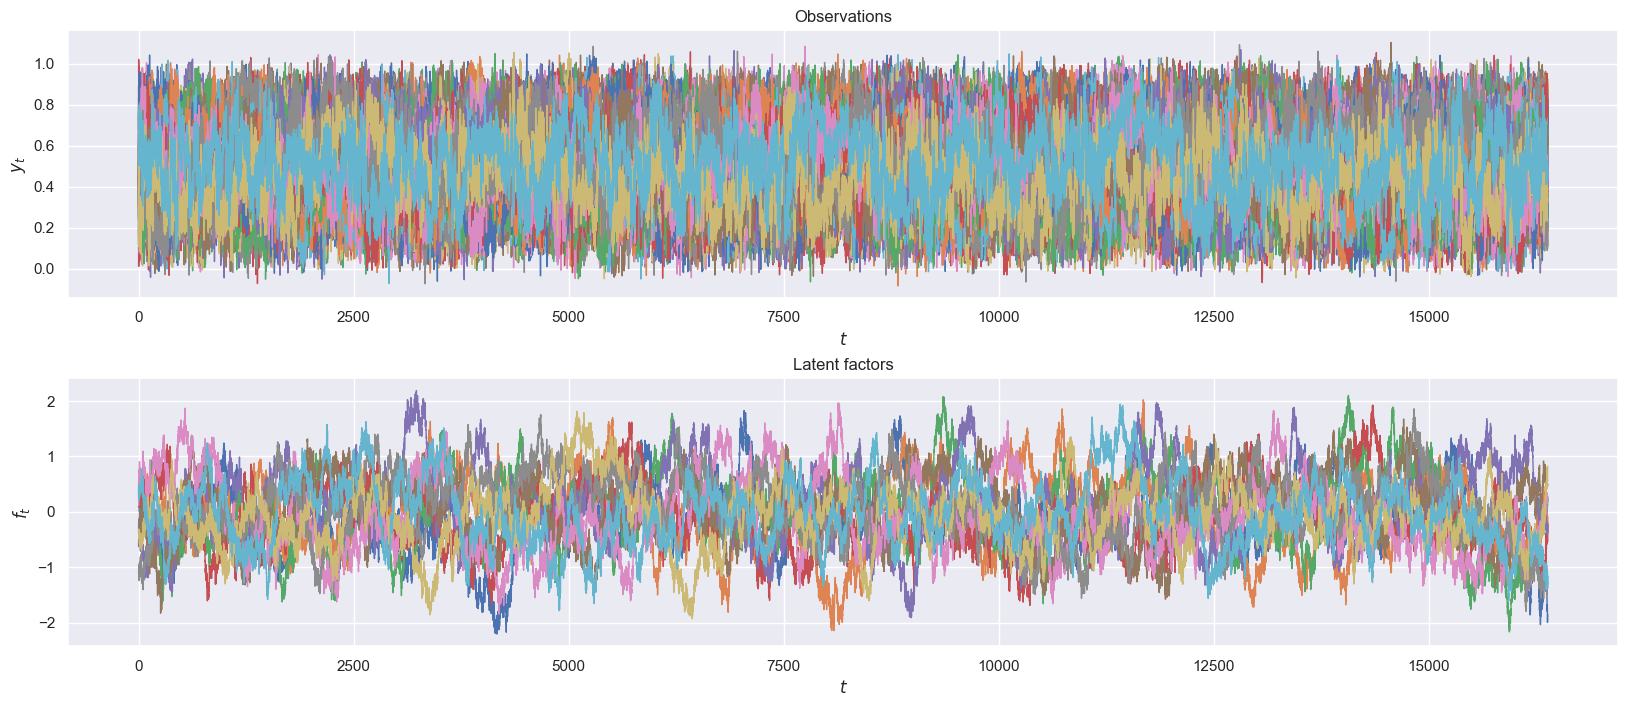

In [16]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=True, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

### Train & val loss

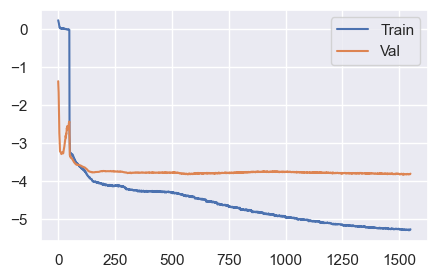

In [17]:
plot_train_hist(train_hist, log=True)

### Convergence of mu of epsilon

In [54]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

NameError: name 'errorProcess' is not defined

### Reconstruction of y

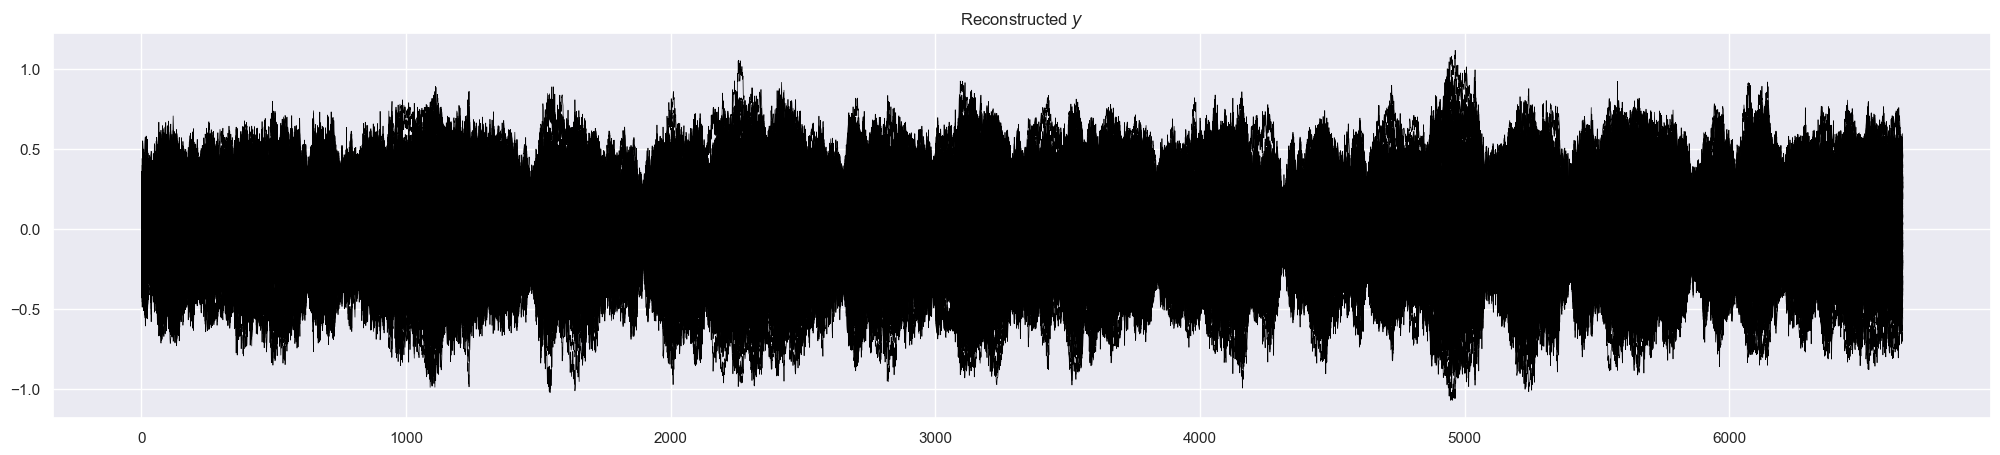

In [55]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


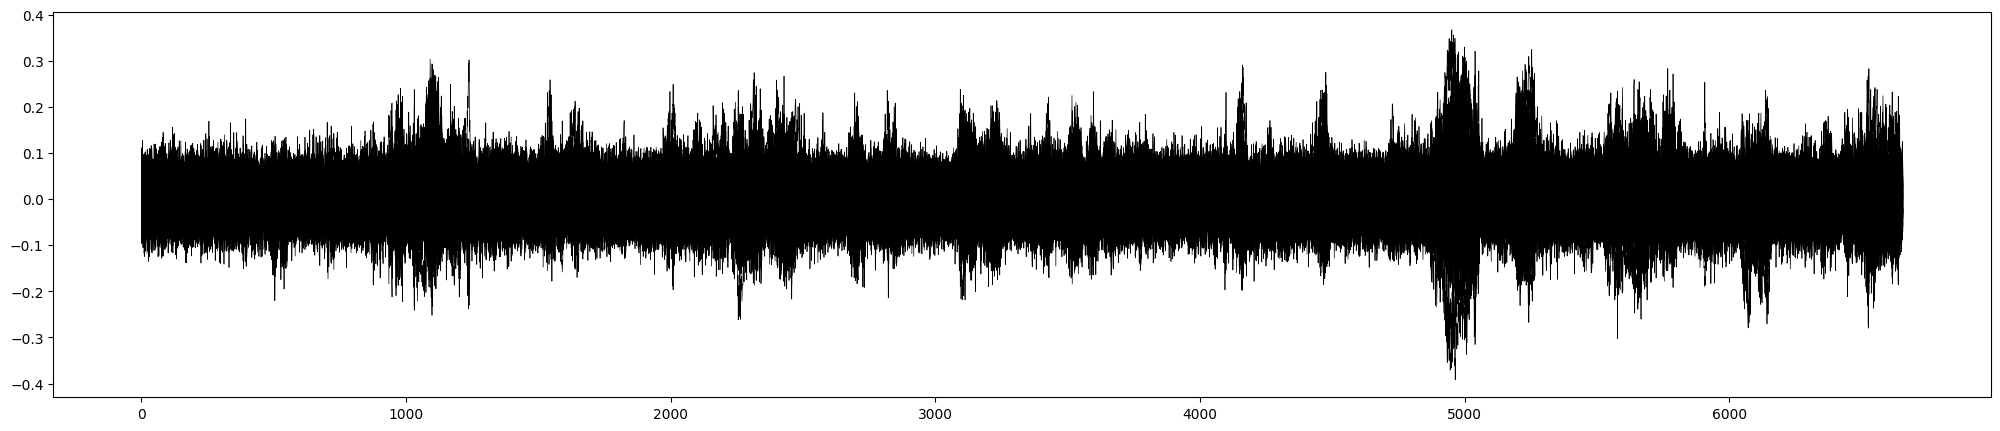

In [39]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

### Factor estimation

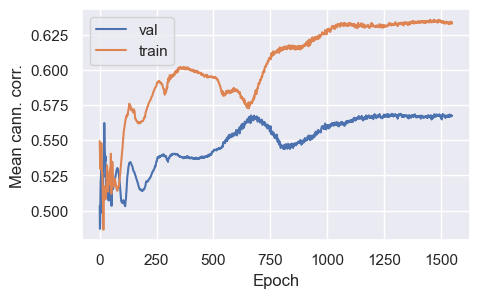

In [18]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'], label='val')
plt.plot(train_hist['train_CCA_mean_corr'], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

In [19]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  
print("cc R2 on test data: ", cca.score(f_test_hat, f_test))  

from evaluation import bootstrapCCA
bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=1000)
print("Bootstrapped cca: mean, std, 95%ci", (np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975])))

y_test_hat = mod(torch.Tensor(y_test).float()).detach().numpy()
print(f'Mse on test data: {np.mean((y_test_hat - y_test)**2)}')

cc on train data: 0.6336761794521805
cc on test data: 0.5561176655286482
cc on train data:  0.6336761057298139
cc on test data:  0.5561175928723902
cc R2 on test data:  0.31755094597543554
Bootstrapped cca: mean, std, 95%ci (0.5603708676466367, 0.005978734214950468, array([0.54888012, 0.57208835]))
Mse on test data: 0.023407144472002983


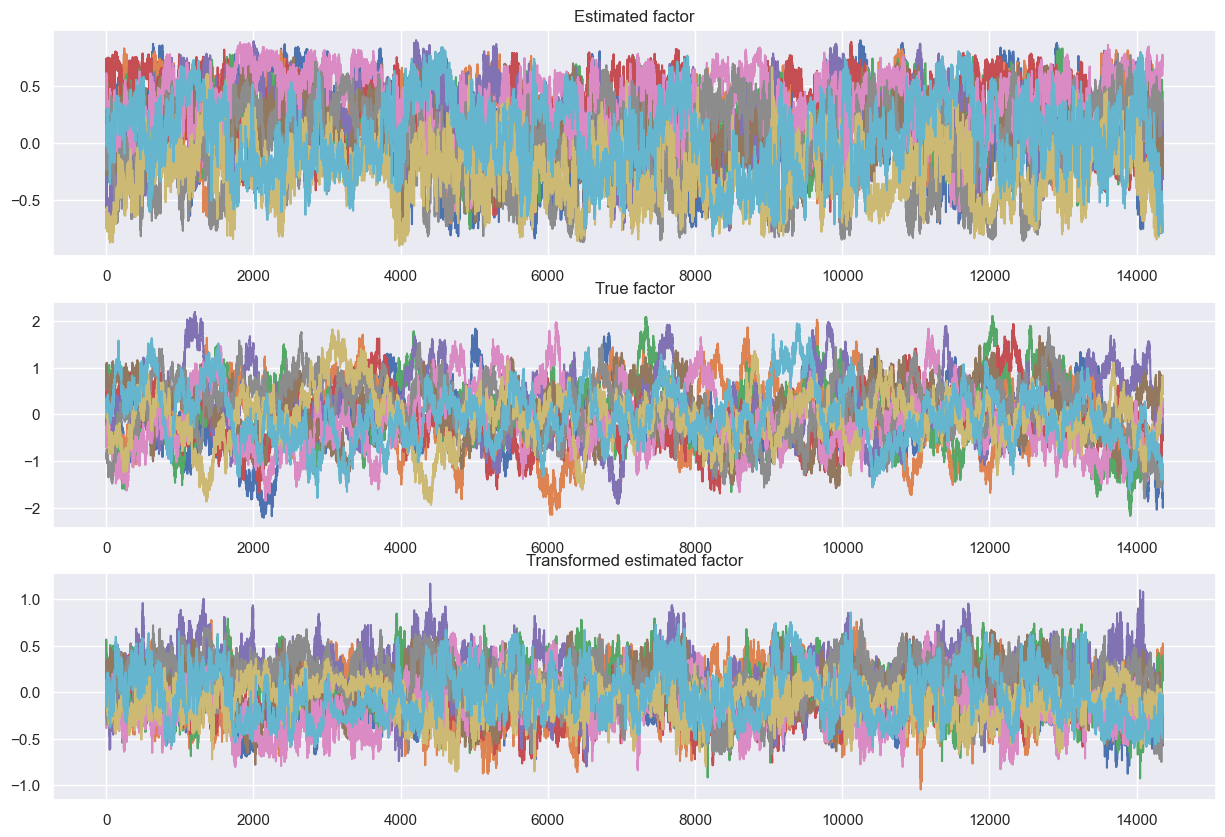

In [20]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

### Forecast

1-step ahead  FMSE on the test set: 0.004881475120782852


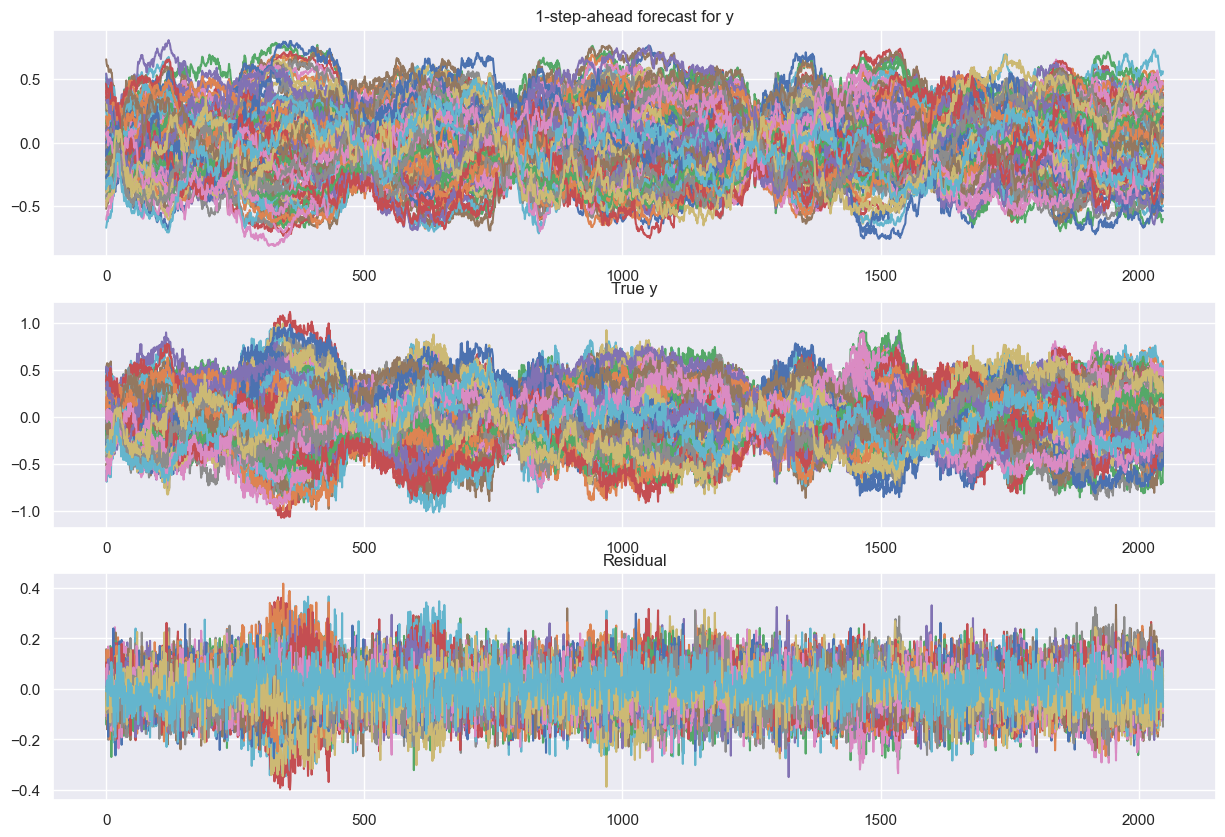

In [59]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

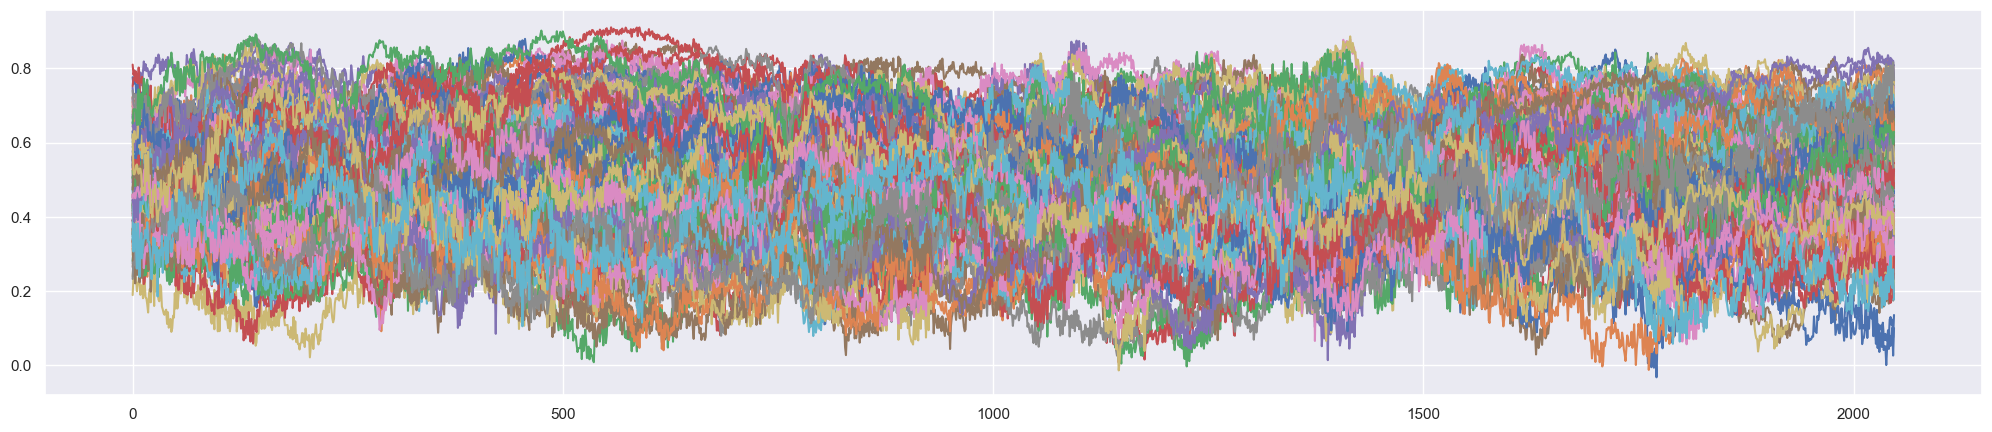

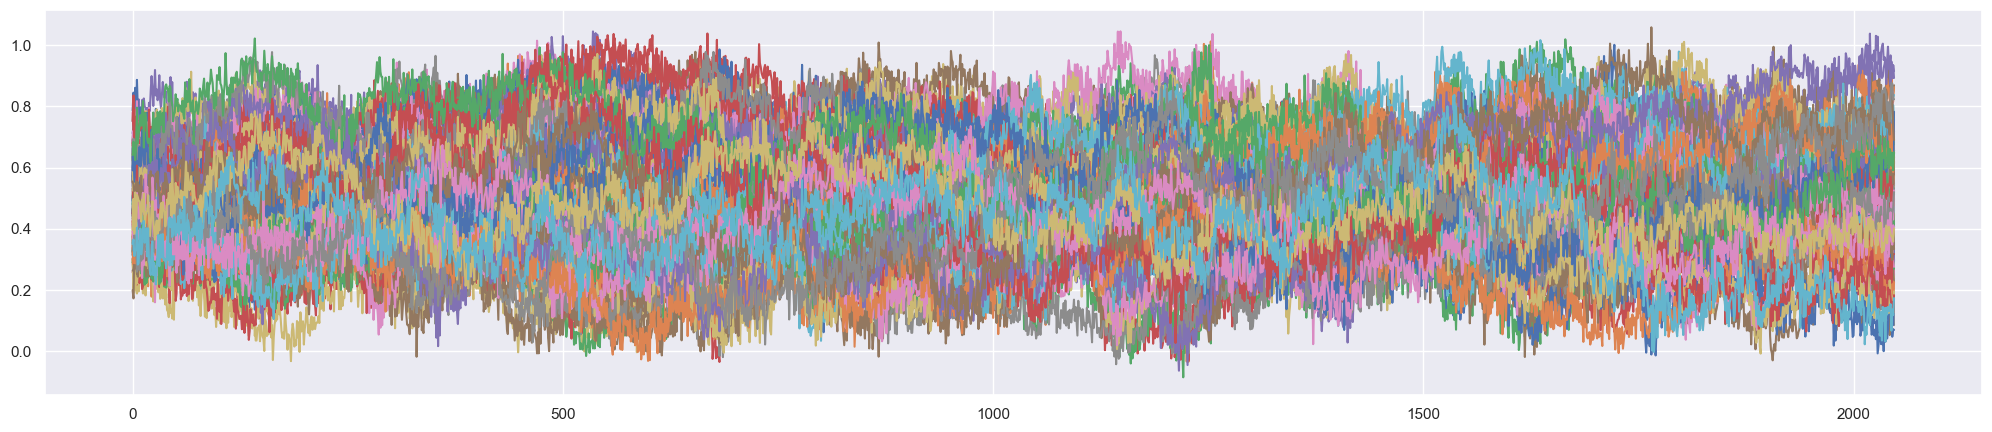

In [16]:
#expanding forecast
ewf = np.load(f"{RESULT_DIR}{dgpIndex}/{experimentName}/expandingForecast.npy")
plt.plot(ewf);
plt.figure()
plt.plot(y_test);


In [22]:
ewmsfe = (y_test - ewf)**2
print("Mean ewfe", np.mean(ewmsfe))

Mean ewfe 0.0031346304
